<a href="https://colab.research.google.com/github/nshamid/Face-Mask-Detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from PIL import Image as PILImage
from tensorflow.keras.preprocessing import image

In [38]:
dataset_path = '/content/Face Mask Dataset.zip'
extract_path = '/content/face-mask-dataset'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [57]:
base_dir = '/content/face-mask-dataset/Face Mask Dataset'

# Data Augmentation dan Splitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 80% training, 20% validation

# Load data Training dan Validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 1053 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [83]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

accuracy = history.history['val_accuracy'][-1]
print(f"Akurasi validasi: {accuracy * 100:.2f}%")

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step - accuracy: 0.6753 - loss: 0.5832 - val_accuracy: 0.8588 - val_loss: 0.3980
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.8249 - loss: 0.4178 - val_accuracy: 0.9160 - val_loss: 0.2477
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.9183 - loss: 0.2003 - val_accuracy: 0.9542 - val_loss: 0.1690
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9356 - loss: 0.2013 - val_accuracy: 0.9427 - val_loss: 0.1856
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9323 - loss: 0.1978 - val_accuracy: 0.9389 - val_loss: 0.1601
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.9364 - loss: 0.1695 - val_accuracy: 0.9427 - val_loss: 0.2033
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.9414 - loss: 0.1765 - val_accuracy: 0.9580 - val_loss: 0.1217
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.9253 - loss: 0.1893 - val_accuracy: 

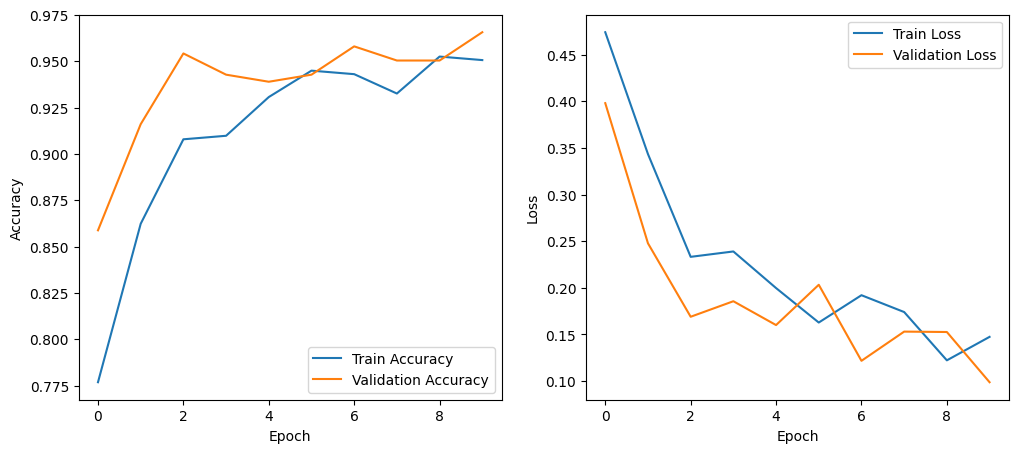

In [85]:
#PLot Training dan Validation Accuracy dan Loss
def plot_learning_curves(history):
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

plot_learning_curves(history)

Saving mentahan_foto.jpg to mentahan_foto.jpg


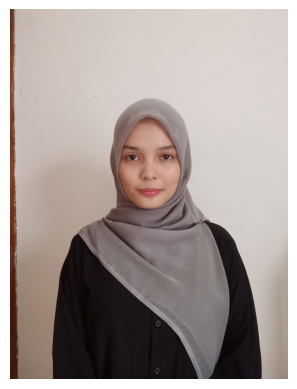

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Prediksi: Without Mask


In [86]:
# Fungsi Prediksi
def predict_mask(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Prediksi: Without Mask"
    else:
        return "Prediksi: With Mask"

uploaded = files.upload()

# Loop
for fn in uploaded.keys():
    path = fn

    # Menampilkan Gambar
    img = PILImage.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    result = predict_mask(path)
    print(result)

In [87]:
#Evaluasi Model
validation_generator.reset()
y_true = validation_generator.classes
y_pred = (model.predict(validation_generator) > 0.5).astype("int32").flatten()

#Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['With Mask', 'Without Mask']))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
Classification Report:
              precision    recall  f1-score   support

   With Mask       0.53      0.52      0.52       131
Without Mask       0.53      0.53      0.53       131

    accuracy                           0.53       262
   macro avg       0.53      0.53      0.53       262
weighted avg       0.53      0.53      0.53       262



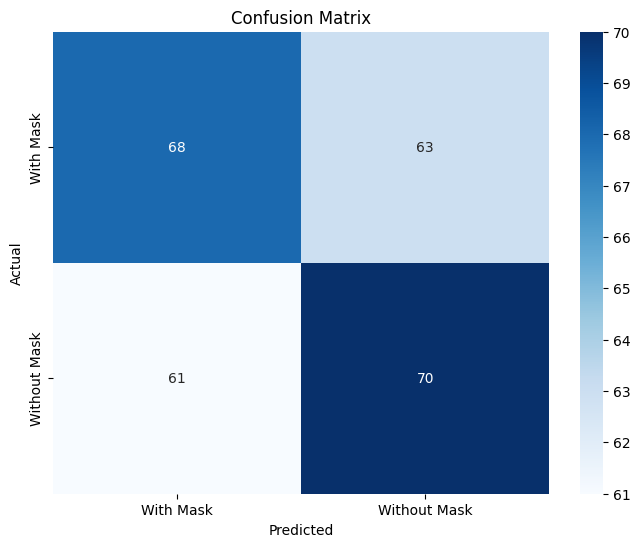

In [88]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['With Mask', 'Without Mask'], yticklabels=['With Mask', 'Without Mask'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step


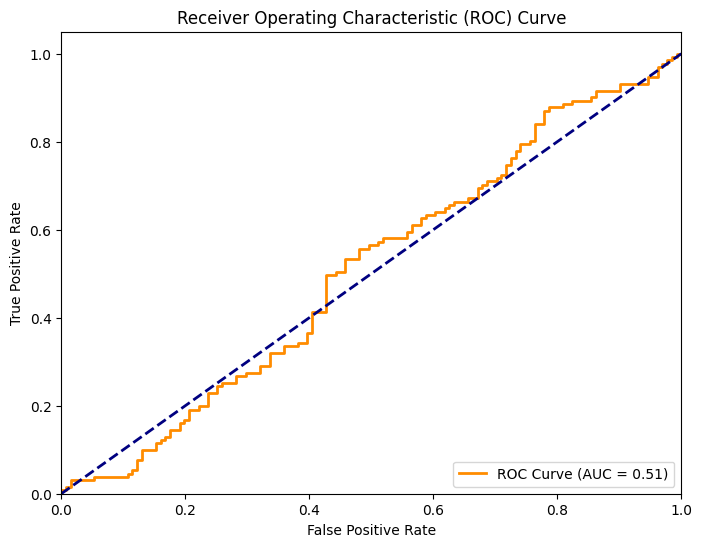

In [89]:
#ROC Curve dan AUC
y_pred_proba = model.predict(validation_generator).ravel()
fpr, tpr, _=roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()